In [1]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

import joblib 
import re
import string
import unicodedata
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt


In [2]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [self.preprocess(text) for text in X]

    def preprocess(self, text):
        # print(textes)
        text = str(text)
        text = text.lower()
        normalized = unicodedata.normalize("NFD", text)
        text = "".join(c for c in normalized if unicodedata.category(c) != "Mn")
        text = re.sub(r'\[.*?\]', '', text)
        text = re.sub(r"\\W", " ", text)
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        text = re.sub(r'<.*?>+', '', text)
        text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
        text = re.sub(r'\n', '', text)
        text = re.sub(r'\w*\d\w*', '', text)
        return text

In [3]:
# Swap between these
# pipeline_lr.joblib
# pipeline_mlp.joblib
# pipeline_rf.joblib
# pipeline_xgb.joblib

stack = joblib.load('../../Models/60-40 Test/pipeline_svm.joblib')

training = pd.read_csv('../../Data Splits/test_data.csv')

training_x = training['article']

training_y = training['label']

x = stack.named_steps['vectorizer'].transform(training_x)
print(x.shape)



(321, 29247)


Metrics for MNB:
Accuracy: 0.8193146417445483
Precision: 0.7428571428571429
Recall: 0.975
F1 Score: 0.8432432432432433
AUC: 0.9739518633540374
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.66      0.79       161
           1       0.74      0.97      0.84       160

    accuracy                           0.82       321
   macro avg       0.85      0.82      0.82       321
weighted avg       0.85      0.82      0.81       321



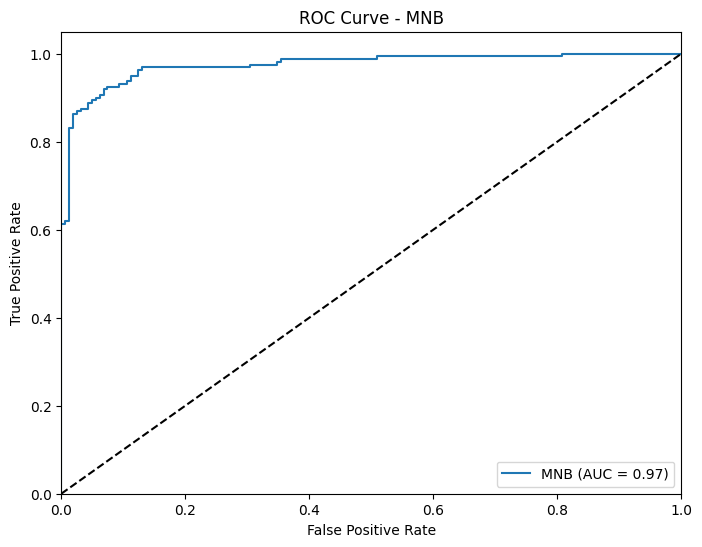

Metrics for LR:
Accuracy: 0.9221183800623053
Precision: 0.9411764705882353
Recall: 0.9
F1 Score: 0.9201277955271565
AUC: 0.981832298136646
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       161
           1       0.94      0.90      0.92       160

    accuracy                           0.92       321
   macro avg       0.92      0.92      0.92       321
weighted avg       0.92      0.92      0.92       321



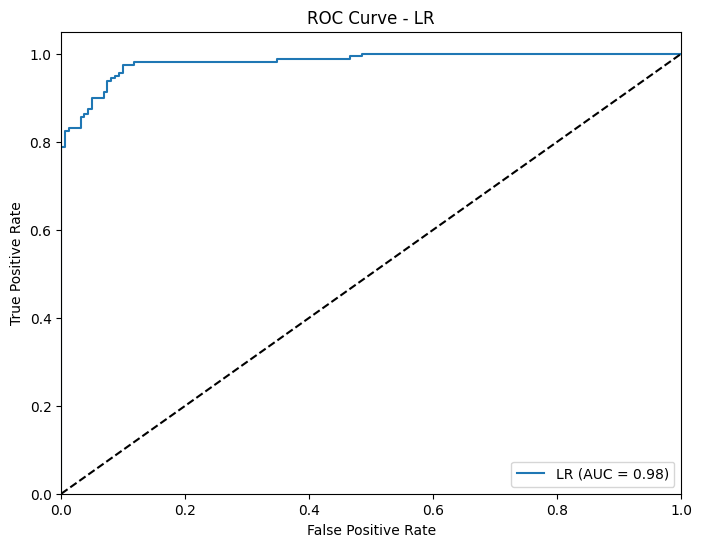

Metrics for RF:
Accuracy: 0.9127725856697819
Precision: 0.9024390243902439
Recall: 0.925
F1 Score: 0.9135802469135802
AUC: 0.9752329192546584
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       161
           1       0.90      0.93      0.91       160

    accuracy                           0.91       321
   macro avg       0.91      0.91      0.91       321
weighted avg       0.91      0.91      0.91       321



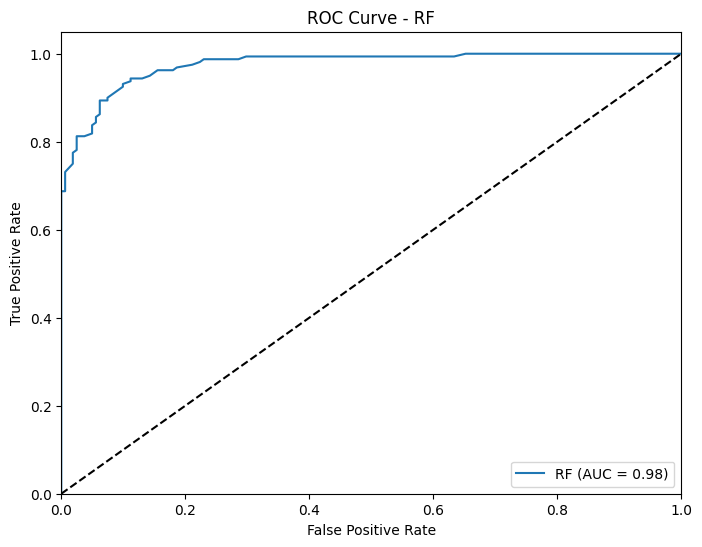

Metrics for KNN:
Accuracy: 0.8691588785046729
Precision: 0.8172043010752689
Recall: 0.95
F1 Score: 0.8786127167630058
AUC: 0.9562305900621118
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.79      0.86       161
           1       0.82      0.95      0.88       160

    accuracy                           0.87       321
   macro avg       0.88      0.87      0.87       321
weighted avg       0.88      0.87      0.87       321



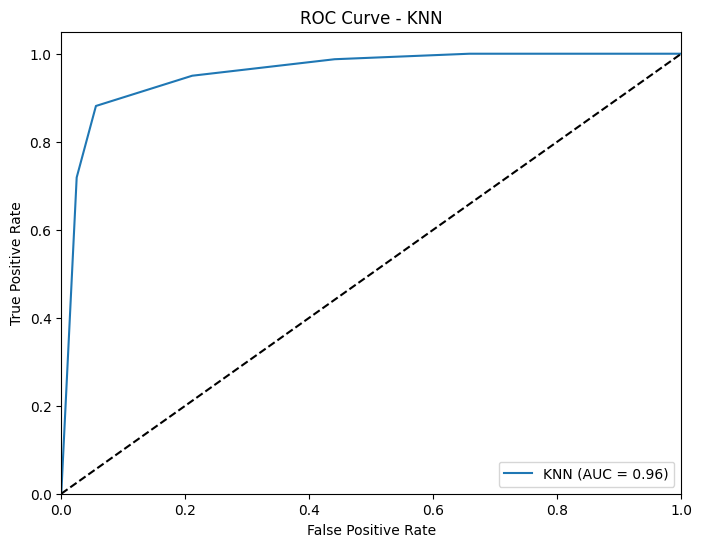

Metrics for SVM:
Accuracy: 0.940809968847352
Precision: 0.9731543624161074
Recall: 0.90625
F1 Score: 0.9385113268608414
AUC: 0.985054347826087
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       161
           1       0.97      0.91      0.94       160

    accuracy                           0.94       321
   macro avg       0.94      0.94      0.94       321
weighted avg       0.94      0.94      0.94       321



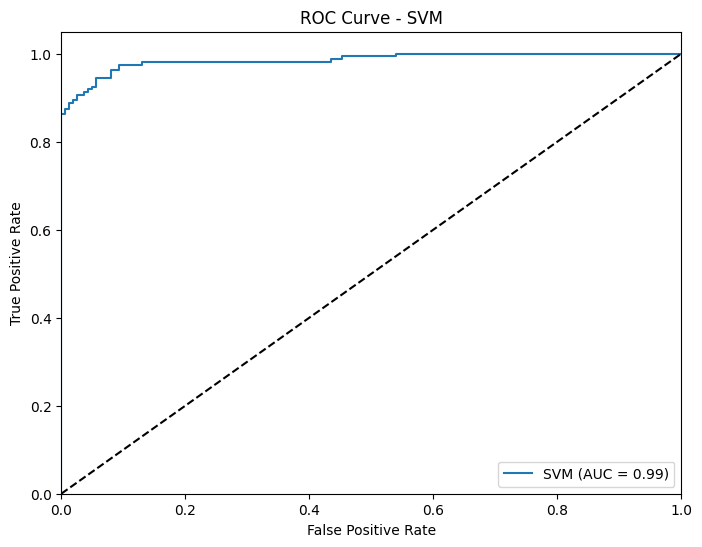

Metrics for Stacking Model:
Accuracy: 0.9345794392523364
Precision: 0.9316770186335404
Recall: 0.9375
F1 Score: 0.9345794392523364
AUC: 0.9887810559006212
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       161
           1       0.93      0.94      0.93       160

    accuracy                           0.93       321
   macro avg       0.93      0.93      0.93       321
weighted avg       0.93      0.93      0.93       321



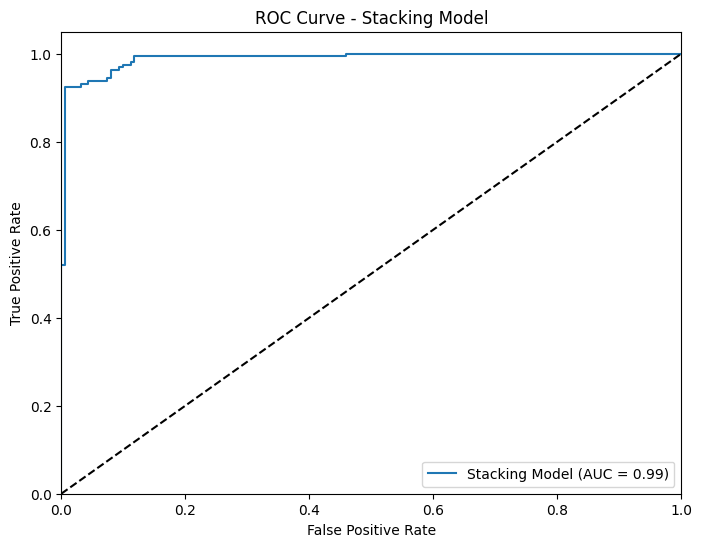

Comparison of Models:
                Accuracy Precision   Recall  F1 Score       AUC
MNB             0.819315  0.742857    0.975  0.843243  0.973952
LR              0.922118  0.941176      0.9  0.920128  0.981832
RF              0.912773  0.902439    0.925   0.91358  0.975233
KNN             0.869159  0.817204     0.95  0.878613  0.956231
SVM              0.94081  0.973154  0.90625  0.938511  0.985054
Stacking Model  0.934579  0.931677   0.9375  0.934579  0.988781


In [4]:
base_names = ['MNB', 'LR', 'RF', 'KNN', 'SVM']
metrics_df = pd.DataFrame(index=base_names + ['Stacking Model'], columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])

vectorized_text = stack.named_steps['vectorizer'].transform(training_x)

# Evaluate base models
for model, name in  zip(stack.named_steps['stacking'].estimators_ , base_names):
    y_pred = model.predict(vectorized_text)
    y_prob = model.predict_proba(vectorized_text)[:, 1]  # Probability for positive class for ROC curve
    
    accuracy = accuracy_score(training_y, y_pred)
    precision = precision_score(training_y, y_pred)
    recall = recall_score(training_y, y_pred)
    f1 = f1_score(training_y, y_pred)
    auc = roc_auc_score(training_y, y_prob)

    print(f"Metrics for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUC: {auc}")
    print(f"Classification Report:\n{classification_report(training_y, y_pred)}")

    # Store metrics in the DataFrame
    metrics_df.loc[name] = [accuracy, precision, recall, f1, auc]

    # ROC Curve
    fpr, tpr, _ = roc_curve(training_y, y_prob)
    roc_auc = roc_auc_score(training_y, y_prob)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.show()


# Evaluate stacking model
stack_y_pred = stack.predict(training_x)
stack_y_prob = stack.predict_proba(training_x)[:, 1]  # Probability for positive class for ROC curve

stack_accuracy = accuracy_score(training_y, stack_y_pred)
stack_precision = precision_score(training_y, stack_y_pred)
stack_recall = recall_score(training_y, stack_y_pred)
stack_f1 = f1_score(training_y, stack_y_pred)
stack_auc = roc_auc_score(training_y, stack_y_prob)

print("Metrics for Stacking Model:")
print(f"Accuracy: {stack_accuracy}")
print(f"Precision: {stack_precision}")
print(f"Recall: {stack_recall}")
print(f"F1 Score: {stack_f1}")
print(f"AUC: {stack_auc}")
print(f"Classification Report:\n{classification_report(training_y, stack_y_pred)}")

# ROC Curve for stacking model
stack_fpr, stack_tpr, _ = roc_curve(training_y, stack_y_prob)
stack_roc_auc = roc_auc_score(training_y, stack_y_prob)

# Store stacking model metrics in the DataFrame
metrics_df.loc['Stacking Model'] = [stack_accuracy, stack_precision, stack_recall, stack_f1, stack_auc]


# Plot ROC Curve for stacking model
plt.figure(figsize=(8, 6))
plt.plot(stack_fpr, stack_tpr, label=f'Stacking Model (AUC = {stack_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Stacking Model')
plt.legend(loc="lower right")
plt.show()

# Display the comparison table
print("Comparison of Models:")
print(metrics_df)